# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from IPython.display import clear_output # clear jupyter notebook

import os

In [2]:
# Read data cleaned in R
data = pd.read_csv("data_modelling.csv")

In [3]:
data.columns

Index(['codigo', 'dep_var', 'f_r2_1_mir', 'f_r2_1_cvar', 'f_r2_1_track_error',
       'f_r2_1_alpha', 'f_r2_1_beta_mercado', 'f_r2_1_beta_size',
       'f_r2_1_beta_value', 'f_r2_1_beta_mom', 'f_r12_2_mir', 'f_r12_2_cvar',
       'f_r12_2_track_error', 'f_r12_2_alpha', 'f_r12_2_beta_mercado',
       'f_r12_2_beta_size', 'f_r12_2_beta_value', 'f_r12_2_beta_mom',
       'f_st_rev_mir', 'f_st_rev_cvar', 'f_st_rev_track_error',
       'f_st_rev_alpha', 'f_st_rev_beta_mercado', 'f_st_rev_beta_size',
       'f_st_rev_beta_value', 'f_st_rev_beta_mom', 'aum', 'inflow', 'outflow',
       'pct_flow', 'shareholders', 'invest_qualificado', 'alavancado',
       'aplic_min_inic', 'forma_condominio', 'fundo_cotas', 'fundo_exclusivo',
       'prazo_receb_resg', 'age', 'year', 'month'],
      dtype='object')

In [4]:
data = data.drop(['aplic_min_inic', 'invest_qualificado', 'prazo_receb_resg'], axis = 1)

In [5]:
data.head()

,codigo,dep_var,f_r2_1_mir,f_r2_1_cvar,f_r2_1_track_error,f_r2_1_alpha,f_r2_1_beta_mercado,f_r2_1_beta_size,f_r2_1_beta_value,f_r2_1_beta_mom,...,outflow,pct_flow,shareholders,alavancado,forma_condominio,fundo_cotas,fundo_exclusivo,age,year,month
0,681,0.031186,-0.000011,-0.016480,0.007125,4.733844e-07,0.457031,-0.227537,0.220901,0.120020,...,0.31215,-0.000074,80833,0.0,1.0,1.0,0.0,25.084189,2005,2
1,744,0.054509,0.044827,-0.014493,0.009129,2.776587e-03,0.302383,-0.046034,0.286058,0.080566,...,55.30907,0.076400,10635,0.0,1.0,1.0,0.0,25.084189,2005,2
2,1041,0.035267,-0.000011,-0.016352,0.007120,8.401630e-05,0.455638,-0.226593,0.220644,0.119665,...,312.85247,-0.001295,877812,0.0,1.0,1.0,0.0,25.084189,2005,2
3,2135,0.043793,-0.000039,-0.035204,0.012994,-9.370196e-04,0.440919,-0.790217,0.571191,-0.010573,...,1.06371,-0.000304,71867,0.0,1.0,0.0,0.0,25.084189,2005,2
4,2151,0.063461,-0.000010,-0.015105,0.006652,1.013640e-05,0.511514,-0.228174,0.196555,0.089096,...,12.11367,-0.000823,62764,0.0,1.0,1.0,0.0,32.607803,2005,2


In [6]:
# Based on the month and year, create a date column
data['date'] = pd.to_datetime([datetime.date(year=y,month=m,day=1) for y, m in zip(data['year'], data['month'])])

# Drop NA, reset index, drop the columns containing month and year
data = data.dropna().reset_index(drop=True).drop(['month', 'year'], axis = 1)

In [7]:
data.shape

(118801, 37)

# Outlier Detection

In [8]:
from sklearn.ensemble import IsolationForest

In [17]:
data_outlier = data.drop(['codigo', 'dep_var', 'date'], axis = 1)

clf = IsolationForest(random_state=42)

clf.fit(data_outlier)

outliers_predicted = clf.predict(data_outlier)

data['scores'] = clf.decision_function(data_outlier)

data['anomaly_score'] = clf.predict(data_outlier)

data[data['anomaly_score']==-1].head()

,codigo,dep_var,f_r2_1_mir,f_r2_1_cvar,f_r2_1_track_error,f_r2_1_alpha,f_r2_1_beta_mercado,f_r2_1_beta_size,f_r2_1_beta_value,f_r2_1_beta_mom,...,pct_flow,shareholders,alavancado,forma_condominio,fundo_cotas,fundo_exclusivo,age,date,scores,anomaly_score
169,28711,-0.052019,0.186618,-0.025197,0.019802,0.007045,0.837887,1.125003,0.490761,-0.061480,...,0.000351,3,0.0,0.0,0.0,1.0,10.740589,2005-04-01,-0.010673,-1
192,78891,-0.026951,-0.000116,-0.035578,0.036308,0.009151,-1.004048,-1.280662,0.548478,0.411624,...,-0.021962,1,0.0,1.0,0.0,0.0,6.691307,2005-04-01,-0.015434,-1
246,28711,0.062671,0.221246,-0.024477,0.016888,0.001899,0.291396,-0.163364,0.316256,0.143868,...,0.400936,4,0.0,0.0,0.0,1.0,10.822724,2005-05-01,-0.010752,-1
260,58246,0.034028,0.320529,-0.020590,0.015444,0.003555,0.474091,0.483223,0.058172,0.299973,...,-1.090191,1,0.0,1.0,0.0,1.0,6.715948,2005-05-01,-0.000791,-1
266,62987,0.045256,-0.000007,-0.124977,0.038980,-0.003747,-0.150490,-0.458486,0.856519,-0.112568,...,-0.246671,13,0.0,1.0,0.0,0.0,8.741958,2005-05-01,-0.016529,-1


In [19]:
data_anomaly = data[data['anomaly_score']==-1]
data_anomaly = data_anomaly.reset_index()

<AxesSubplot:xlabel='date'>

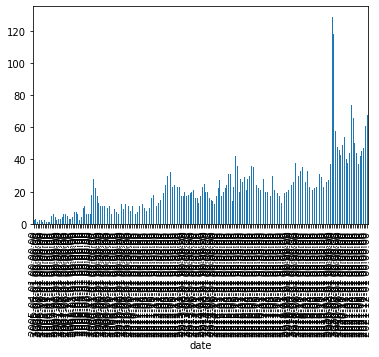

In [30]:
data_anomaly['date'].groupby(data_anomaly['date']).count().plot(kind="bar")

In [32]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
data_anomaly['date'].groupby(data_anomaly['date']).count()

date
2005-04-01     2
2005-05-01     3
2005-06-01     1
2005-07-01     2
2005-08-01     2
              ..
2021-08-01    42
2021-09-01    45
2021-10-01    47
2021-11-01    61
2021-12-01    68
Name: date, Length: 191, dtype: int64

# Make Predictions for the data

In [8]:
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error

import time # measure time for model to train

# Separate train and test dataset into X_train, X_test, y_train, y_test
def prepare_train_test(data_train, data_test):
    # Separate in dependent and independent variables
    y_train, X_train = data_train[['dep_var']], data_train.drop('dep_var', axis = 1)
    y_test, X_test = data_test[['dep_var']], data_test.drop('dep_var', axis = 1)

    # Reshape the dependente variable
    y_train, y_test = y_train.values.ravel(), y_test.values.ravel()
    
    return X_train, X_test, y_train, y_test

# Make any pre-processing needed and fit model and predict
def fit_pred_model(model_class, X_train, X_test, y_train, y_test, model_name):
    
    # These models use distances, so we need to scale our features
    if model_name in ['KNeighborsRegressor', 'SVR']:
        scaler = StandardScaler()
        scaler.fit(X_train)
        
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    # Call model
    regressor = model_class
    
    # Fit
    regressor.fit(X_train, y_train)
    
    # Predict
    y_pred = regressor.predict(X_test)
    
    return y_pred

In [9]:
# List of models we are going to use
models = [XGBRegressor(random_state=42), ExtraTreesRegressor(random_state=42), 
          AdaBoostRegressor(random_state=42), GradientBoostingRegressor(random_state=42), 
          DummyRegressor(), LGBMRegressor(random_state=42),
          ElasticNet(random_state=42), RandomForestRegressor(random_state=42),
          LinearRegression(), Lasso(random_state=42),  Ridge(random_state=42),
          SVR(), KNeighborsRegressor(), DecisionTreeRegressor(random_state=42)]

# Create folder to store predictions
os.mkdir('predictions')

for model in models:
    pred_df = pd.DataFrame(columns = ['funds_code', 'prediction', 'true_value', 'date', 'execution_time'])
    for year in range(2008, 2022): 
        for month in range(1, 13):
            if len(str(month)) == 1:
                holdout_date = f"{str(year)}-0{str(month)}-01"
            else:
                holdout_date = f"{str(year)}-{str(month)}-01"

            print(type(model).__name__)
            print(holdout_date)

            # Train = all data before test; Test = specific month
            data_train = data.loc[data['date'] < holdout_date].drop(['codigo', 'date'], axis = 1)
            data_test = data.loc[data['date'] == holdout_date]

            # Save the funds' code
            funds_code = data_test['codigo'].to_list()

            # Now we eliminate the two useless columns for the modeling
            data_test = data_test.drop(['codigo', 'date'], axis = 1)

            # Get X_train, X_test, y_train, y_test
            X_train, X_test, y_train, y_test = prepare_train_test(data_train, data_test)

            st = time.time() # Start stopwatch

            model_pred = fit_pred_model(model, X_train, X_test, y_train, y_test, type(model).__name__)

            et = time.time() # Stop stopwatch

            model_pred = pd.DataFrame(list(zip(funds_code, model_pred, y_test)), 
                                      columns = ['funds_code', 'prediction', 'true_value'])
            
            model_pred['date'] = holdout_date
            # Add execution time to dataframe
            model_pred['execution_time'] = et - st
            # Eval metrics

            pred_df = pd.concat([pred_df, model_pred])

            pred_df.to_csv(f'predictions/{type(model).__name__}.csv', index = False)

            clear_output(wait=True)

DecisionTreeRegressor
2021-12-01
